In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.dummy import DummyClassifier

ImportError: cannot import name 'CalibrationDisplay'

## 3.1. Logistic Regression

- Import preprocessed features as DataFrames and target variables as Series

In [17]:
# training and test sets with original data distribution

X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv', squeeze=True)

X_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv', squeeze=True)

In [19]:
# resampled / balanced training sets

X_train_rus = pd.read_csv('data/X_train_rus.csv')
y_train_rus = pd.read_csv('data/y_train_rus.csv', squeeze=True)

X_train_ros = pd.read_csv('data/X_train_ros.csv')
y_train_ros = pd.read_csv('data/y_train_ros.csv', squeeze=True)

X_train_smote = pd.read_csv('data/X_train_smote.csv')
y_train_smote = pd.read_csv('data/y_train_smote.csv', squeeze=True)

### 3.1.1 Initial Model Building
[Back to top](#top)

- First logistic regression model: We set the maximal number of iterations to ``max_iter=200`` which allows the solver to converge. Apart from that we use the default hyperparameter values.

In [20]:
# Create pipeline
pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200, random_state=42))
log_reg = pipe['logisticregression']

# Scale and fit model on training data
%time pipe.fit(X_train, y_train)

Wall time: 5.01 s


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=200, random_state=42))])

In [21]:
# Predict labels
y_pred = pipe.predict(X_test)

In [30]:
pipe.score(X_test, y_test)

0.9119127516778524

Our first impression is a good accuracy of 91%. However, having the data imbalance in mind, we will evaluate the model in detail.

### 3.1.3 Model Evaluation 

Count of 0 in test set: 16307, (91.2025%)
Count of 1 in test set: 1573, (8.7975%)


C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='readmitted_within_30_days', ylabel='count'>

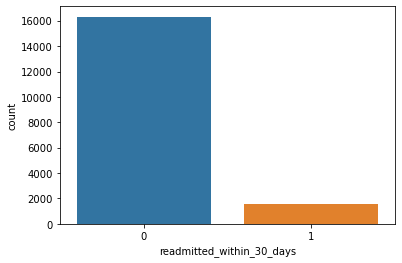

In [69]:
count_0 = (y_test == 0).sum()
count_1 = (y_test == 1).sum()

print(f'Count of 0 in test set: {count_0}, ({round(count_0 / len(y_test) * 100, 4)}%)')
print(f'Count of 1 in test set: {count_1}, ({round(count_1 / len(y_test) * 100, 4)}%)')

sns.countplot(y_test)

The '0' class has a share of 91.2% of all target values in the test data. This means a simple estimator which is always predicting 0 will have an accuracy of 91.2% while evaluated on this data set.

In [159]:
# Classifier which is always predicting the majority class label

simplest_clf = DummyClassifier()
simplest_clf.fit(X_train, y_train)
simplest_clf.score(X_test, y_test)

0.9120246085011185

Consequently, our trained logistic regression model does not have a satisfying accuracy since it is in fact less accurate than the simplest model imaginable!

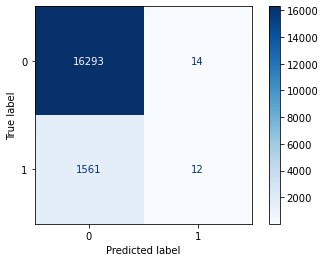

In [160]:
plot_confusion_matrix(pipe, X_test, y_test,cmap='Blues')

In the confusion matrix, the data imbalance becomes obvious. The majority of the instances in the test dataset is classified correctly ($\rightarrow$ accuracy), the large majority in the 'True Negative' section. Out of the 17880 instances, the classifier predicted only 26 instances as '1', and only 12 of these predictions were correct. As we are interested in a model which identifies patients which will be readmitted to the hospital, this model is as worse as it can get. This becomes even clearer if we normalize the counts display in the confusion matrix over the true conditions:

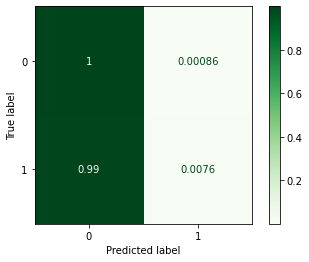

In [161]:
plot_confusion_matrix(pipe, X_test, y_test,cmap='Greens', normalize='true')

While only 0.086% of all '0' instances are misclassified as '1', 99% of all '1' instances are misclassified as '0'!

In [32]:
# Print evaluation metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.46      0.01      0.02      1573

    accuracy                           0.91     17880
   macro avg       0.69      0.50      0.48     17880
weighted avg       0.87      0.91      0.87     17880



The classification report summarized the already observed difference in performance with respect to the different target classes. We have an overall good accuracy because the classifier performs well in regard to the majority class where it shows perfect recall while also giving a good precision. In regard to the minority class in which we are particularly interested in, the classifier shows an abysmal performance, having the worst possible recall while not even having a good precision.

### 3.1.2 Hyperparameter Tuning
[Back to top](#top)

In the following section, we try to optimize the logistic regression model with regard to its accuracy score. As discussed in the previous section, accuracy might not be the best evaluation metric for our problem. However, an improvement of the accuracy could potentially improve the model: Since the recall for class 0 is already almost 100%, a siginificant increase in accuracy can only be obtained if the classification performance for class 1 improves.


We start by having a detailed look at the hyperparameters of scikit-learn's implementation in order to decide how to vary the model. We conduct a randomized search on a large parameter grid before finetuning with a grid search on a narrowly defined grid.

In [73]:
# Show hyperparameters and their values
log_reg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 200,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Hyperparameters to be varied:

- ``penalty``: By default, a l2 regularization is performed. Alternatively, the logistic regression can be done without any regularization or the penalty term can be changed to l1 norm or an elastic net. We opt for an elastic net which includes l1 and l2 regularization (see ``l1_ratio``).

- ``l1_ratio``: The combination of l1 and l2 penalty in the elastic net can be selected by a ratio between 0 and 1. A value of 0 equals l2 regularization while the value of 1 equals l1 regularization.

- ``C``: Inverse of regularization strength. A lower value results in a stronger regularization with 1.0 being the default.

- ``solver``: The algorithm which solves the optimization problem. We opt for the 'saga' solver, a stochastic average gradient descent implementation which supports elastic net regularization and is recommended for large datasets (https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression).


- ``fit_intercept``: Specification if an intercept should be added to the regression function


- ``max_iter``: Maximum number of iterations as limit for the solver to converge.

- ``tol``: Tolerance of the stopping criteria, by default: 0.0001.

- ``warm_start``: When set to True, the solution of the previous call is used to fit as initialization (False by default.

- ``class_weight``: Weights associated with the different classes in the target variable. By default, all classes are weighted the same. Apart from manually assigning weights to each class, we can use the 'balanced' option which automatically adjust weights inversely proportional to class frequencies. We will deal with class imbalances later.

After having a detailed look at the possible hyperparameter values, we create the following parameter grid which will be given to the randomized search algorithm:

In [162]:
param_dist = {'logisticregression__solver': ['saga'],
              'logisticregression__penalty': ['elasticnet', 'none'],
              'logisticregression__l1_ratio': np.linspace(0, 1, 11), # try different elastic nets
              'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], # vary regularization strength
              'logisticregression__fit_intercept': [False, True], 
              'logisticregression__tol': [0.000001, 0.00001, 0.0001, 0.001, 0.01], # vary stopping threshold
              'logisticregression__warm_start': [False, True],         
             }

We conduct a 5-fold cross validated search where 15 randomly selected parameter combinations are tried:

In [163]:
random_search = RandomizedSearchCV(estimator=pipe, 
                                   param_distributions = param_dist,
                                   n_iter=15,
                                   n_jobs=-1, 
                                   verbose=1)
%time random_search.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_logistic.py:1319: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))


Wall time: 16min 55s


C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=200,
                                                                 random_state=42))]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000,
                                                                  10000],
                                        'logisticregression__fit_intercept': [False,
                                                                              True],
                                        'logisticregression__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 

In [121]:
rs_cv_results = pd.DataFrame(random_search.cv_results_)
rs_cv_results.sort_values(by = 'mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__warm_start,param_logisticregression__tol,param_logisticregression__solver,param_logisticregression__penalty,param_logisticregression__l1_ratio,param_logisticregression__fit_intercept,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.595674,0.024435,0.050346,0.014247,False,0.0001,saga,elasticnet,0.7,False,0.0001,"{'logisticregression__warm_start': False, 'log...",0.912006,0.912006,0.912006,0.911998,0.911998,0.912003,0.000004,1
10,27.420257,1.732929,0.059649,0.038101,False,1e-06,saga,elasticnet,0.9,True,0.001,"{'logisticregression__warm_start': False, 'log...",0.912006,0.912006,0.912006,0.911998,0.911998,0.912003,0.000004,1
1,58.491284,2.902807,0.041043,0.020408,True,0.0001,saga,elasticnet,0.5,True,0.01,"{'logisticregression__warm_start': True, 'logi...",0.911820,0.912379,0.911726,0.911998,0.911718,0.911928,0.000247,3
9,7.559923,0.961167,0.050105,0.010382,True,0.001,lbfgs,none,0.1,True,10,"{'logisticregression__warm_start': True, 'logi...",0.911913,0.912099,0.911447,0.911718,0.911159,0.911667,0.000334,4
17,5.557338,0.275277,0.037070,0.008289,False,1e-05,lbfgs,none,0.6,True,100,"{'logisticregression__warm_start': False, 'log...",0.911913,0.912099,0.911447,0.911718,0.911159,0.911667,0.000334,4
14,8.686891,0.775253,0.062305,0.012031,True,0.0001,lbfgs,none,1,True,10,"{'logisticregression__warm_start': True, 'logi...",0.911913,0.912099,0.911447,0.911718,0.911159,0.911667,0.000334,4
19,35.338465,5.784976,0.035072,0.007341,False,0.001,saga,none,0.8,True,1,"{'logisticregression__warm_start': False, 'log...",0.911913,0.912099,0.911447,0.911718,0.911159,0.911667,0.000334,4
2,8.951134,0.329113,0.053369,0.003910,True,1e-06,lbfgs,none,0.4,True,0.001,"{'logisticregression__warm_start': True, 'logi...",0.911913,0.912099,0.911447,0.911718,0.911159,0.911667,0.000334,4
6,7.406373,1.676695,0.048828,0.010125,False,1e-06,lbfgs,none,0.3,False,100,"{'logisticregression__warm_start': False, 'log...",0.620246,0.619407,0.911353,0.639321,0.621889,0.682443,0.114689,9
13,7.171771,1.187307,0.057441,0.003633,True,1e-05,lbfgs,none,0.7,False,1,"{'logisticregression__warm_start': True, 'logi...",0.620246,0.619407,0.911353,0.639321,0.621889,0.682443,0.114689,9


In [164]:
random_search.best_params_

{'logisticregression__warm_start': False,
 'logisticregression__tol': 1e-05,
 'logisticregression__solver': 'saga',
 'logisticregression__penalty': 'none',
 'logisticregression__l1_ratio': 0.1,
 'logisticregression__fit_intercept': True,
 'logisticregression__C': 1}

In [165]:
# Predict labels
y_pred = random_search.best_estimator_.predict(X_test)

# Print metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     16307
           1       0.48      0.01      0.02      1573

    accuracy                           0.91     17880
   macro avg       0.70      0.50      0.48     17880
weighted avg       0.87      0.91      0.87     17880



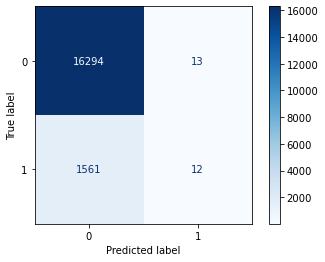

In [166]:
plot_confusion_matrix(random_search.best_estimator_, X_test, y_test,cmap='Blues')

In [176]:
param_grid = {'logisticregression__C': [0.001, 0.01, 0,1, 1, 10, 100, 1000],
              'logisticregression__l1_ratio': np.linspace(0, 1, 6),
              'logisticregression__penalty': ['elasticnet']}

In [177]:
grid_search = GridSearchCV(estimator=random_search.best_estimator_,
                         param_grid=param_grid,
                         cv=3)

In [178]:
%time grid_search.fit(X_train, y_train)

C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\fabio\anaconda3\envs\fastai-cpu-v0.7\lib\site-packages\

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_test, y_pred))

### Handling data imbalance

- Calibration

In [ ]:
y_prob = clf.predict_proba(X_test)

In [ ]:
CalibrationDisplay.from_predictions()

In [ ]:
# fit and calibrate model on training data
calibrated_model = CalibratedClassifierCV(clf)
calibrated_model.fit(X_train, y_train)

- Threshold Moving